l'objectif de cette partie est d'extraire les zones à risques d'innodation à partir du fichier shapefile Georisques 


In [2]:
# Importation du package Cartiflette 
!pip install py7zr geopandas openpyxl tqdm s3fs
!pip install PyYAML xlrd
!pip install git+https://github.com/inseefrlab/cartiflette

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.1 MB/s eta 0:00:00
  Cloning https://github.com/inseefrlab/cartiflette to /tmp/pip-req-build-_si2i1ji
  Running command git clone --filter=blob:none --quiet https://github.com/inseefrlab/cartiflette /tmp/pip-req-build-_si2i1ji
  Resolved https://github.com/inseefrlab/cartiflette to commit 2e38b5f829df6a6fa1578268112ff88853c9a4bf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 63.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 44.4 MB/s eta 0:00:00
  Created wheel for cartiflette: filename=cartiflette-0.0.2-py3-none-any.whl size=56573 sha256=7e59f26a71f86d2e94fde43e66cedc1ab47120e738ca086278e0ae3cc7c1d1e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-1javga96/wheels/e2/79/c0/4a3

/tmp/ipykernel_20100/853940336.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
/tmp/ipykernel_20100/853940336.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude


INSEE_COM
13004    153
13096    131
30276    125
30341    111
30003     86
        ... 
76740      1
76517      1
76453      1
76123      1
76366      1
Name: count, Length: 4939, dtype: int64


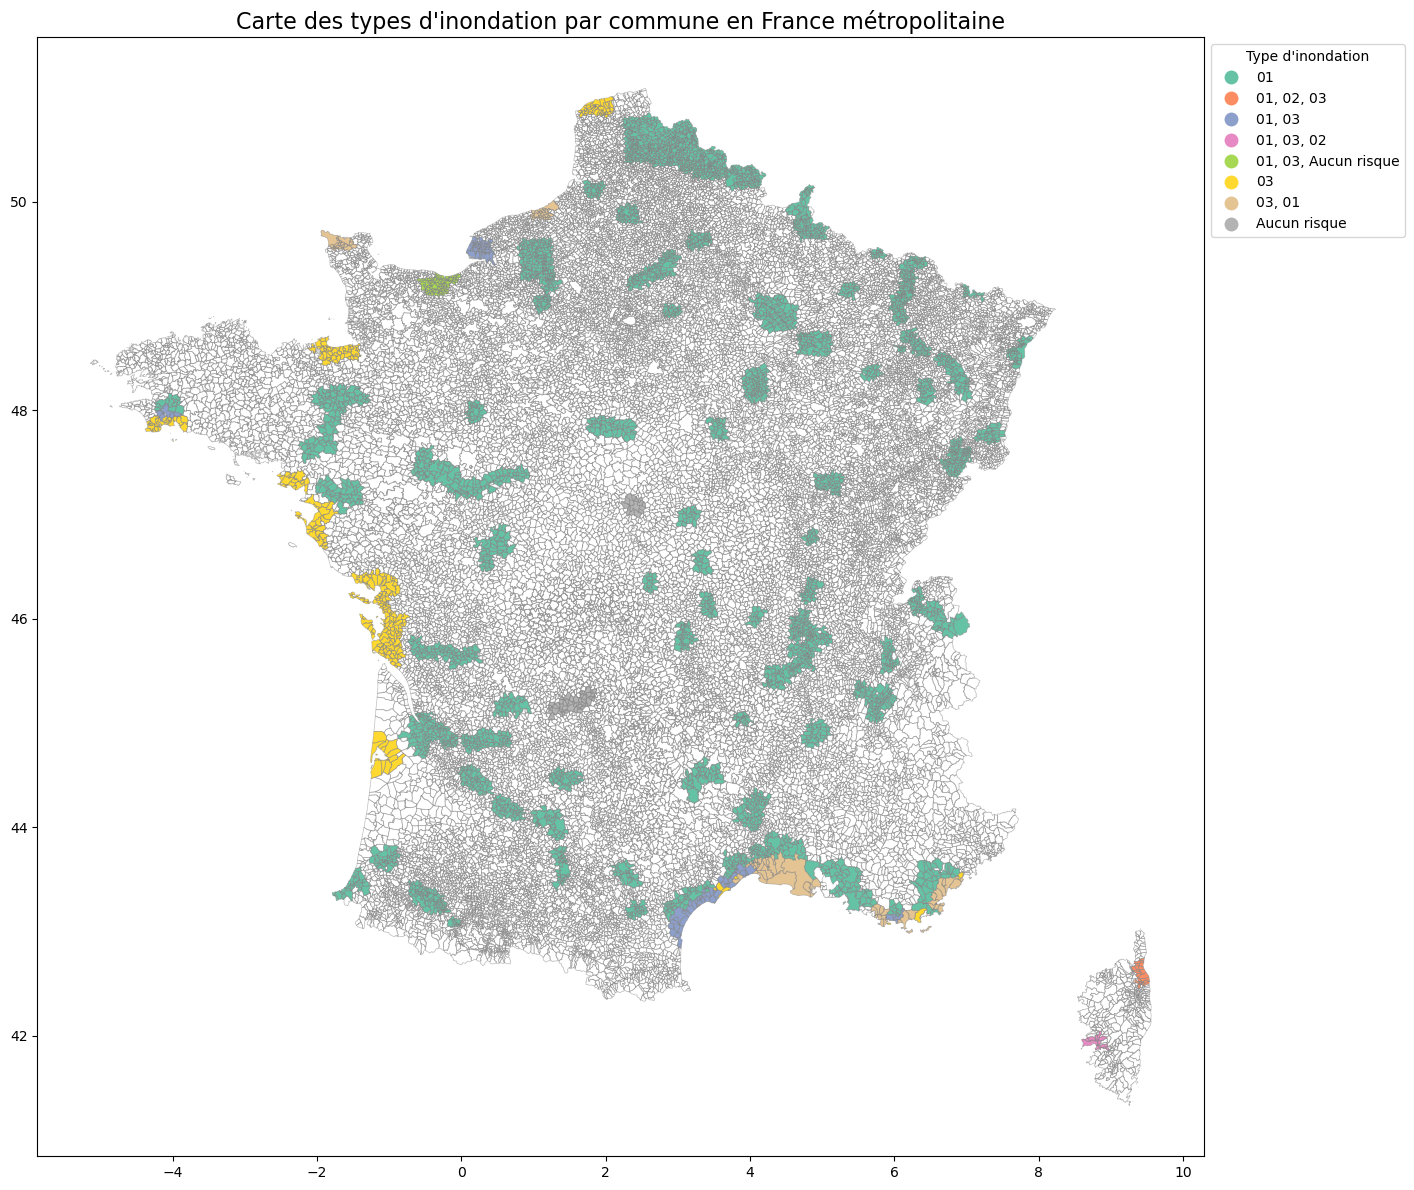

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Charger les données géographiques du Shapefile
shapefile_path = "Shp file : Zones innondables/n_carte_inond_s.shp"
gdf = gpd.read_file(shapefile_path)

# Filtrer pour garder uniquement les points en France métropolitaine
gdf = gdf[
    (gdf.geometry.centroid.y >= 41) & (gdf.geometry.centroid.y <= 51) &  # Filtrer par latitude
    (gdf.geometry.centroid.x >= -5) & (gdf.geometry.centroid.x <= 10)   # Filtrer par longitude
]

# Télécharger le fond de carte via Cartiflette
france = carti_download(
    values=["France"],
    crs=4326,
    borders="COMMUNE",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

# Filtrer les communes métropolitaines pour le fond de carte
france = france.loc[france["INSEE_REG"] > 10]

# Vérifier et aligner les CRS
if gdf.crs != france.crs:
    gdf = gdf.to_crs(france.crs)

# Effectuer une jointure spatiale entre les points du Shapefile et les communes
joined = gpd.sjoin(gdf, france, how="left", predicate="intersects")

print(joined["INSEE_COM"].value_counts())
# Remplacer les valeurs nulles dans 'typ_inond1' par une valeur par défaut
joined["typ_inond1"] = joined["typ_inond1"].fillna("Aucun risque")  # Replace NaN with "Aucun risque"

# Agréger les risques pour chaque commune en combinant tous unique risks
joined["typ_inond1"] = joined["typ_inond1"].astype(str)  # Convert to string for categorical handling
commune_risks = joined.groupby("INSEE_COM")["typ_inond1"].apply(lambda x: ', '.join(x.unique())).reset_index()

# Ajouter les risques au fond de carte
france = france.merge(commune_risks, on="INSEE_COM", how="left")

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Ajouter les limites des communes
france.boundary.plot(ax=ax, linewidth=0.5, color="gray", alpha=0.5)

# Remplir les communes avec les risques associés (Categorical colormap)
france.plot(
    column="typ_inond1",
    ax=ax,
    legend=True,
    cmap="Set2",  # Use a categorical colormap
    legend_kwds={
        "title": "Type d'inondation",
        "loc": "upper left",
        "bbox_to_anchor": (1, 1),
    },
)

# Ajouter un titre
ax.set_title("Carte des types d'inondation par commune en France métropolitaine", fontsize=16)

plt.tight_layout()
plt.show()


Cette carte n'est pas poreuse en termes de données et assez grossière sur les risques. En effet, on va, à la cordonnée géographique près associer son risque d'innondation pour une commune dont empiriquement, il semblerait y avoir une forte corrélation d'après le papier de Tristan Ancel et Thierry Kamionka Les effets du risque d'inondation sur la valeur foncière des maisons en France : le Gard. 


